# Mult Frequency Random Forest Expectation

A Notebook dedicated to the organization and creation of random forest regressors and multi frequency datasets used to create forward looking views of asset class returns.  

In [1]:
import numpy as np
import pandas as pd
from xbbg.blp import bdp, bdh
from datetime import date, timedelta

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error


## Investment Universe

The set of asset classes used for analysis

In [2]:
# Define the opportunity set of assets

asset_class = {
    # Benchmark Asset Classes
    'RU30INTR Index': 'US Equity',
    'LBUSTRUU Index': 'US Aggregate',

    # Portfolio Primary Asset Classes
    'RU10INTR Index': 'US LC Equity',
    'RU20INTR Index': 'US SC Equity',
    'LT08TRUU Index': 'US Intermediate Treasury',
    'LUTLTRUU Index': 'US Long Treasury',
    'LUACTRUU Index': 'US Corporate',
    'LF98TRUU Index': 'US High Yield',

    # Portfolio Secondary Asset Classes
    'LBUTTRUU Index': 'US TIPS',
    'I31732US Index': 'EM USD Sovereign',
    'BCOMTR Index': 'Commodities'
}

# Get last Friday's date
def get_last_friday():
    today = date.today()
    offset = (today.weekday() + 2) % 7  # Calculate days to subtract to get to last Friday
    last_friday = today - timedelta(days=offset)
    return last_friday


# Download Total Return Price Data
asset_start_date = date(1998, 9, 1)
end_date = get_last_friday()

# Download Total Return Price Data
price_data = bdh(asset_class.keys(), 'RT116', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.resample('B').last().ffill()
price_data.columns = [asset_class[asset] for (asset, _) in price_data.columns]

# Calculate daily, weekly, and monthly returns
returns = {
    'daily': price_data.pct_change()[1:],
    'weekly': price_data.resample('W').last().pct_change()[1:],
    'monthly': price_data.resample('ME').last().pct_change()[1:]
}

price_data.head(10)


,US Equity,US Aggregate,US LC Equity,US SC Equity,US Intermediate Treasury,US Long Treasury,US Corporate,US High Yield,US TIPS,EM USD Sovereign,Commodities
1998-09-01,1940.38,818.30,2014.388,1323.10,881.59,1065.91,980.02,521.40,104.4681,160.5910,122.477
1998-09-02,1938.36,817.61,2009.833,1340.45,880.37,1064.95,978.79,521.29,104.5064,160.9558,122.310
1998-09-03,1918.83,819.29,1991.019,1316.01,881.79,1069.83,981.79,521.20,104.5349,156.0434,124.978
1998-09-04,1904.39,819.92,1974.354,1318.99,882.07,1072.61,982.96,521.30,104.5997,155.6425,125.193
1998-09-07,1904.39,819.92,1974.354,1318.99,882.07,1072.61,982.96,521.30,104.5997,155.6425,125.193
1998-09-08,1998.53,819.52,2073.037,1375.82,882.70,1066.86,981.62,521.72,104.6260,156.8203,125.746
1998-09-09,1964.15,822.77,2038.879,1340.66,885.94,1075.77,987.07,522.13,104.9389,156.9999,124.991
1998-09-10,1914.80,828.21,1987.080,1311.34,891.98,1088.81,996.48,522.13,105.6781,149.8918,126.972
1998-09-11,1967.39,825.42,2042.045,1344.41,889.36,1081.54,992.15,521.50,105.6019,150.3665,126.384
1998-09-14,2007.87,825.14,2085.600,1360.30,889.16,1080.54,991.75,521.55,105.5856,150.8407,126.530


## Functions

A set of analysis function to help determine if our models are adding value

In [3]:
def calculate_mse_reduction(y_test, y_pred):
    """
    This function calculates the Root Mean Squared Error (RMSE) reduction for each asset in a given test set.
    It compares the MSE of the model's predictions against a naive RMSE (standard devation).

    Parameters:
    y_test (pd.DataFrame): The actual values for the test set. Each column represents a different asset.
    y_pred (pd.DataFrame): The predicted values for the test set. Each column represents a different asset.

    Returns:
    results (pd.DataFrame): A DataFrame with the MSE for the model and the naive baseline, and the MSE reduction.
    """

    # Initialize an empty dictionary to store the results
    results = {}

    # Calculate the MSE and standard devation for each asset
    for asset in y_test.columns:

        # Calculate the MSE of the model's predictions
        model_mse = root_mean_squared_error(y_test[asset], y_pred[asset])

        # Calculate the MSE of the naive baseline
        naive_mse = y_test[asset].std()

        # Store the results
        results[asset] = model_mse, naive_mse

    # Convert the results to a DataFrame
    results = pd.DataFrame(results, index=['Model RMSE', 'Naive RMSE']).transpose()
    # Calculate the MSE reduction
    results['RMSE Improvement'] = results['Naive RMSE'] - results['Model RMSE']
    # Sort the results by the MSE reduction
    results = results.sort_values('RMSE Improvement', ascending=False)

    # Also plot the predictions
    y_pred.plot(grid=True)

    return results

In [4]:
import pandas as pd

def add_lag_features(df, lags=5):
    """
    Function to add multiple lag features to each column of the DataFrame, up to a specified number of lags.

    Parameters:
    df (pd.DataFrame): The input DataFrame with features/columns to lag.
    lags (int): The number of lagged features to create for each column. Defaults to 5.

    Returns:
    pd.DataFrame: A DataFrame with the original features and additional lagged features for each original column.
                  For each column in the original DataFrame, this function efficiently creates 'lags' number of new columns,
                  each representing a lagged version of the original column by 1 to 'lags' periods.
    """
    # Create a list to hold the original DataFrame and the new lagged DataFrames
    df_list = [df]

    # Generate lagged DataFrames and add them to the list
    for lag in range(1, lags + 1):
        lag_df = df.shift(lag)
        lag_df = lag_df.rename(columns=lambda x: f'{x}_lag_{lag}')
        df_list.append(lag_df)

    # Concatenate all DataFrames in the list
    df_lagged = pd.concat(df_list, axis=1)
    
    return df_lagged

## Datasets

The Following code chunks create daily, weekly, and monthly datasets used for prediction. 

### Daily Datasets

In [5]:
# Download the daily returns of the benchmark assets
window = 40
daily_prices = (1 + returns['daily']).cumprod()
moving_avg = daily_prices.rolling(window=window).mean()
rolling_vol = returns['daily'].rolling(window=window).std() * np.sqrt(window)
momentum = (1 - daily_prices / moving_avg)
momentum = momentum / rolling_vol

momentum.columns = [f'{asset} Momentum' for asset in momentum.columns]
rolling_vol.columns = [f'{asset} Volatility' for asset in rolling_vol.columns]

#### Momentum

Ryan's momentum gauge. Percent above / below the 40 moving average normalized by trailing 40 day volatility. 

In [6]:
momentum = {
    'daily': momentum,
    'weekly': momentum.resample('W').last(),
    'monthly': momentum.resample('ME').last()
}

#### Volatility

Ryans rollign 40 day volatility. 

In [7]:
volatility = {
    'daily': rolling_vol,
    'weekly': rolling_vol.resample('W').last(),
    'monthly': rolling_vol.resample('ME').last()
}

#### Yields

US 3 month, 10 Year, 10 Year Breakeven, and 10Y-3M spread. 

In [8]:
# Download the daily returns of the benchmark assets
yields_dict = {
    'USGG3M Index': '3M',
    'USGG10YR Index': '10Y',
    'ACMTP10  Index': '10Y TP',
    'USGGBE10 Index': '10Y BE',
}

# Download the yield data
yield_data = bdh(yields_dict.keys(), 'PX_LAST', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
yield_data.index = pd.to_datetime(yield_data.index)
yield_data = yield_data.resample('B').last().ffill()
yield_data.columns = [yields_dict[asset] for (asset, _) in yield_data.columns]

yields = {
    'daily': yield_data,
    'weekly': yield_data.resample('W').last(),
    'monthly': yield_data.resample('ME').last()
}

yield_data.head()

,3M,10Y,10Y TP,10Y BE
1998-09-01,4.901,5.062,0.7275,1.2636
1998-09-02,4.890,5.068,0.6937,1.2412
1998-09-03,4.838,5.028,0.6550,1.2131
1998-09-04,4.856,5.013,0.6330,1.2206
1998-09-07,4.855,5.011,0.6330,1.2106


#### VIX and Volume

The Vix index and Volume of the S&P 500

In [9]:
# Download volatility and volume data
vol_dict = {
    'VIX Index': 'VIX',
    'VOLSPX Index': 'VOL'
}

# Download the yield data
vol_data = bdh(vol_dict.keys(), 'PX_LAST', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
vol_data.index = pd.to_datetime(vol_data.index)
vol_data = vol_data.resample('B').last().ffill()
vol_data.columns = [vol_dict[asset] for (asset, _) in vol_data.columns]

# Record daily, weekly, and monthly volatility data
vol = {
    'daily': vol_data,
    'weekly': vol_data.resample('W').last(),
    'monthly': vol_data.resample('ME').last()
}

vol_data.head()


,VIX,VOL
1998-09-01,36.48,1123.37
1998-09-02,36.76,776.48
1998-09-03,41.43,763.99
1998-09-04,43.31,664.08
1998-09-07,43.31,664.08


#### Price to Earnings

Large and Small cap Price to Earnings

In [10]:
# Download volatility and volume data
pe_dict = {
    'RU10INTR Index': 'US LC Equity',
    'RU20INTR Index': 'US SC Equity',
}

# Download the yield data
pe_data = bdh(pe_dict.keys(), 'BEST_PE_RATIO', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
pe_data.index = pd.to_datetime(pe_data.index)
pe_data = pe_data.resample('B').last().ffill()
pe_data.columns = [pe_dict[asset] + '_PE' for (asset, _) in pe_data.columns]

# Record daily, weekly, and monthly volatility data
pe = {
    'daily': pe_data,
    'weekly': pe_data.resample('W').last(),
    'monthly': pe_data.resample('ME').last()
}

pe_data.head()

,US LC Equity_PE,US SC Equity_PE
1998-09-01,21.5023,17.6569
1998-09-02,21.3740,17.8758
1998-09-03,21.2295,17.5588
1998-09-04,21.1624,17.7397
1998-09-07,21.1624,17.7026


#### Dollar

US Dollar Index

In [11]:
# Download volatility and volume data
usd_dict = {
    'DXY Curncy': 'USD'
}

# Download the yield data
usd_data = bdh(usd_dict.keys(), 'PX_LAST', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
usd_data.index = pd.to_datetime(usd_data.index)
usd_data = usd_data.resample('B').last().ffill()
usd_data.columns = [usd_dict[asset] for (asset, _) in usd_data.columns]

# Record daily, weekly, and monthly volatility data
usd = {
    'daily': usd_data,
    'weekly': usd_data.resample('W').last(),
    'monthly': usd_data.resample('ME').last()
}

usd_data.head()

,USD
1998-09-01,99.19
1998-09-02,99.40
1998-09-03,98.38
1998-09-04,98.20
1998-09-07,97.87


### Weekly Datasets

#### Spreads

US credit and high yield spreads

In [12]:
# Download volatility and volume data
spread_dict = {
    'LUACOAS Index': 'Corp Spreads',
    'LF98OAS Index': 'HY Spreads',
}

# Download the yield data
spread_data = bdh(spread_dict.keys(), 'PX_LAST', asset_start_date, end_date, Fill='P', Days='A')

# Resample to bussiness days, forward fill missing values, and format asset names
spread_data.index = pd.to_datetime(spread_data.index)
spread_data = spread_data.resample('W').last().ffill()
spread_data.columns = [spread_dict[asset] for (asset, _) in spread_data.columns]

# Record daily, weekly, and monthly volatility data
spread = {
    'weekly': spread_data.resample('W').last(),
    'monthly': spread_data.resample('ME').last()
}

spread_data.head()

,Corp Spreads,HY Spreads
1998-09-06,1.23,5.08
1998-09-13,1.23,5.08
1998-09-20,1.23,5.08
1998-09-27,1.23,5.08
1998-10-04,1.23,5.65


#### Sentiment

Bull / Bearish Sentiment and the put call ratio

In [13]:
# Download the daily returns of the benchmark assets
sentiment_dict = {
    'AAIIBULL Index': 'Bullish Sentiment',
    'PCUSEQTR Index': 'Put Call Ratio'
}

# Download the yield data
sentiment_data = bdh(sentiment_dict.keys(), 'PX_LAST', asset_start_date, end_date, Per='W')

# Resample to bussiness days, forward fill missing values, and format asset names
sentiment_data.index = pd.to_datetime(sentiment_data.index)
sentiment_data = sentiment_data.resample('W').last().ffill()
sentiment_data.columns = [sentiment_dict[asset] for (asset, _) in sentiment_data.columns]

sentiment = {
    'weekly': sentiment_data.resample('W').last(),
    'monthly': sentiment_data.resample('ME').last()
}

sentiment_data.head()


,Bullish Sentiment,Put Call Ratio
1998-09-06,23.0,0.72
1998-09-13,29.0,0.54
1998-09-20,34.0,0.79
1998-09-27,34.0,0.57
1998-10-04,32.0,0.71


### Monthly Datasets

#### Taylor Rule

In [29]:

# Download the data
taylor_dict = {
    'TAYLUSB  Index': 'US_Taylor',
    'TAYLEAB  Index': 'EU_Taylor',
    'TAYLJPB  Index': 'JP_Taylor',
    'TAYLGBB  Index': 'GB_Taylor',
}

# Download the yield data
taylor_data = bdh(taylor_dict.keys(), 'PX_LAST', asset_start_date, end_date, Per='M')

# Resample to bussiness days, forward fill missing values, and format asset names
taylor_data.index = pd.to_datetime(taylor_data.index)
taylor_data = taylor_data.resample('ME').last().ffill()
taylor_data.columns = [taylor_dict[asset] for (asset, _) in taylor_data.columns]

taylor = {
    'monthly': taylor_data.resample('ME').last()
}

taylor_data.head()


,US_Taylor,EU_Taylor,JP_Taylor,GB_Taylor
1998-09-30,3.21,1.60,0.70,2.95
1998-10-31,3.38,1.70,0.70,2.80
1998-11-30,3.46,1.55,0.65,2.65
1998-12-31,3.63,1.65,0.75,2.90
1999-01-31,3.71,1.60,0.50,2.80


#### Recession Probability 

Cleveland Fed's probability of recession as predicted by the yield curve


In [15]:
# Download the data
recession_dict = {
    'CLEVPFYC Index': 'Recession Probability'
}

# Download the yield data
recession_data = bdh(recession_dict.keys(), 'PX_LAST', asset_start_date, end_date, Per='M')

# Resample to bussiness days, forward fill missing values, and format asset names
recession_data.index = pd.to_datetime(recession_data.index)
recession_data = recession_data.resample('ME').last().ffill()
recession_data.columns = [recession_dict[asset] for (asset, _) in recession_data.columns]


recession = {
    'monthly': recession_data.resample('ME').last()
}

recession_data.head()

,Recession Probability
1998-09-30,9.16
1998-10-31,11.68
1998-11-30,16.39
1998-12-31,17.91
1999-01-31,20.64


## Investment Models

The following section houses the sub models used to predict asset class returns. 



In [16]:
features = {}
predictions = {}
training_cutoff = date.today() - timedelta(days=365 * 10)

### Model 1

Frequency:
- Daily

Datasets:
- Momentum
- Volatility
- Yields
- VIX
- Volume

Best Parameters Found:
- 'rf__n_estimators': 16
- 'rf__max_depth': 2
- 'rf__min_samples_split': 2
- 'rf__min_samples_leaf': 10

In [17]:
best_params = {
    'rf__max_depth': 2,
    'rf__min_samples_leaf': 100,
    'rf__min_samples_split': 2,
    'rf__n_estimators': 36
}
search = False

In [18]:
model = 'model_1'
features[model] = {}

# Define the features and target
features[model]['X'] = pd.concat([
    yields['daily'],
    volatility['daily'],
    momentum['daily'], 
    vol['daily'],
    pe['daily'],
    usd['daily'],
], axis=1)

features[model]['X'] = add_lag_features(features[model]['X'], lags=20).dropna()
features[model]['y'] = returns['daily'].shift(-1).dropna()

# Align the features and target
features[model]['Index'] = features[model]['X'].index.intersection(features[model]['y'].index)
features[model]['X'] = features[model]['X'].loc[features[model]['Index']]
features[model]['y'] = features[model]['y'].loc[features[model]['Index']]

# Split the data into training and testing sets
X_train = features[model]['X'].loc[:training_cutoff]
X_test = features[model]['X'].loc[training_cutoff:]
y_train = features[model]['y'].loc[:training_cutoff]
y_test = features[model]['y'].loc[training_cutoff:]

In [19]:
# Model 1 pipeline
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestRegressor(n_jobs=-1))
])

# Model 1 hyperparameters
param_grid = {
    'rf__n_estimators': [i ** 2 for i in range(4, 11, 2)],
    'rf__max_depth': [2],
    'rf__min_samples_split': [2],
    'rf__min_samples_leaf': [i ** 2 for i in range(8, 14, 2)],
}

# Model 1 grid search
grid = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=20))

In [20]:
# Fit the model and find the best hyperparameters if search is True
if search:
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

# Set the best hyperparameters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
best_params

{'rf__max_depth': 2,
 'rf__min_samples_leaf': 100,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 36}

,Model RMSE,Naive RMSE,RMSE Improvement
US High Yield,0.003233,0.003236,3.560007e-06
US Corporate,0.003675,0.003675,-1.720404e-07
US Long Treasury,0.008804,0.008802,-2.138719e-06
US Aggregate,0.002918,0.002916,-2.738302e-06
US Intermediate Treasury,0.001942,0.001939,-3.066802e-06
US SC Equity,0.014115,0.014112,-3.328709e-06
US TIPS,0.003417,0.003413,-4.151747e-06
EM USD Sovereign,0.003999,0.003994,-4.945781e-06
Commodities,0.009080,0.009075,-5.210761e-06
US Equity,0.011230,0.011224,-5.365186e-06


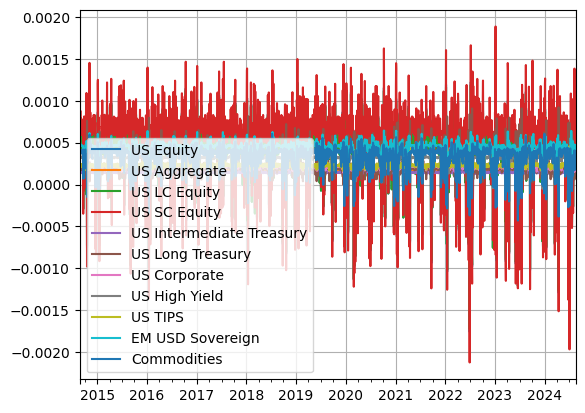

In [21]:
# Predict the returns for the test set
y_test_df = pd.DataFrame(y_test, index=features[model]['Index'][-len(y_test):], columns=y_test.columns)
y_pred_df = pd.DataFrame(pipe.predict(X_test), index=features[model]['Index'][-len(y_test):], columns=y_test.columns)

# Assignign all predictions to the predictions dictionary
predictions[model] = pd.DataFrame(pipe.predict(features[model]['X']), index=features[model]['X'].index, columns=y_test.columns)

# Calculate the MSE reduction for the test set
calculate_mse_reduction(y_test_df, y_pred_df)

### Model 2

Frequency:
- Weekly

Datasets:
- Momentum
- Volatility
- Yields
- VIX
- Volume
- Spreads
- Sentiment

Best Parameters Found:
- 'rf__n_estimators': None
- 'rf__max_depth': None
- 'rf__min_samples_split': None
- 'rf__min_samples_leaf': None

In [22]:
best_params = {
    'rf__max_depth': None,
    'rf__min_samples_leaf': None,
    'rf__min_samples_split': None,
    'rf__n_estimators': None
}
search = True

In [23]:
model = 'model_2'
features[model] = {}

# Define the features and target
features[model]['X'] = pd.concat(
    [
        yields['weekly'],
        volatility['weekly'],
        momentum['weekly'],
        vol['weekly'],
        pe['weekly'],
        usd['weekly'],
        spread['weekly'],
        sentiment['weekly']
    ],
    axis=1
).dropna()

# Add lagged features
features[model]['X'] = add_lag_features(features[model]['X'], lags=4).dropna()
features[model]['y'] = returns['weekly'].shift(-1).dropna()

# Align the features and target
features[model]['Index'] = features[model]['X'].index.intersection(features[model]['y'].index)
features[model]['X'] = features[model]['X'].loc[features[model]['Index']]
features[model]['y'] = features[model]['y'].loc[features[model]['Index']]

# Split the data into training and testing sets
X_train = features[model]['X'].loc[:training_cutoff]
X_test = features[model]['X'].loc[training_cutoff:]
y_train = features[model]['y'].loc[:training_cutoff]
y_test = features[model]['y'].loc[training_cutoff:]

In [24]:
# Model 2 pipeline
pipe = Pipeline([
    ('rf', RandomForestRegressor(n_jobs=-1))
])

# Model 2 hyperparameters
param_grid = {
    'rf__n_estimators': [i for i in range(2, 11, 2)],
    'rf__max_depth': [i for i in range(2, 11, 2)],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [i ** 2 for i in range(8, 15, 2)],
}

# Model 2 grid search
grid = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=10))

In [25]:
# Fit the model and find the best hyperparameters if search is True
if search:
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

# Set the best hyperparameters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
best_params

{'rf__max_depth': 6,
 'rf__min_samples_leaf': 144,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 10}

,Model RMSE,Naive RMSE,RMSE Improvement
US Long Treasury,0.018554,0.018563,0.000009
Commodities,0.019783,0.019790,0.000007
US Corporate,0.009609,0.009604,-0.000005
US High Yield,0.010244,0.010238,-0.000005
US Intermediate Treasury,0.004216,0.004209,-0.000007
US Aggregate,0.006495,0.006482,-0.000013
US TIPS,0.007592,0.007573,-0.000019
US SC Equity,0.031114,0.031080,-0.000035
US Equity,0.024030,0.023969,-0.000061
US LC Equity,0.023781,0.023718,-0.000064


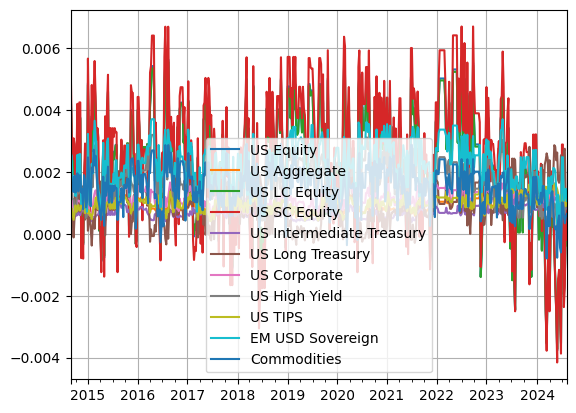

In [26]:
# Predict the returns for the test set
y_test_df = pd.DataFrame(y_test, index=features[model]['Index'][-len(y_test):], columns=y_test.columns)
y_pred_df = pd.DataFrame(pipe.predict(X_test), index=features[model]['Index'][-len(y_test):], columns=y_test.columns)

# Assignign all predictions to the predictions dictionary
predictions[model] = pd.DataFrame(pipe.predict(features[model]['X']), index=features[model]['X'].index, columns=y_test.columns)

# Calculate the MSE reduction for the test set
calculate_mse_reduction(y_test_df, y_pred_df)

### Model 3

Frequency:
- Monthly

Datasets:
- Taylor Rule
- Recession Probability

Best Parameters Found:
- 'rf__n_estimators': None
- 'rf__max_depth': None
- 'rf__min_samples_split': None
- 'rf__min_samples_leaf': None

In [56]:
best_params = {
    'rf__max_depth': 2,
    'rf__min_samples_leaf': 100,
    'rf__min_samples_split': 2,
    'rf__n_estimators': 36
}
search = True

In [57]:
model = 'model_3'
features[model] = {}

# Define the features and target
features[model]['X'] = pd.concat([
    taylor['monthly'],
    recession['monthly']
], axis=1)

features[model]['X'] = add_lag_features(features[model]['X'], lags=20).dropna()
features[model]['y'] = returns['monthly'].shift(-1).dropna()

# Align the features and target
features[model]['Index'] = features[model]['X'].index.intersection(features[model]['y'].index)
features[model]['X'] = features[model]['X'].loc[features[model]['Index']]
features[model]['y'] = features[model]['y'].loc[features[model]['Index']]

# Split the data into training and testing sets
X_train = features[model]['X'].loc[:training_cutoff]
X_test = features[model]['X'].loc[training_cutoff:]
y_train = features[model]['y'].loc[:training_cutoff]
y_test = features[model]['y'].loc[training_cutoff:]

In [58]:
# Model 3 pipeline
pipe = Pipeline([
    ('rf', RandomForestRegressor(n_jobs=-1))
])

# Model 2 hyperparameters
param_grid = {
    'rf__n_estimators': [i for i in range(2, 11, 2)],
    'rf__max_depth': [i for i in range(2, 11, 2)],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [i ** 2 for i in range(8, 15, 2)],
}

# Model 2 grid search
grid = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=10))

In [59]:
# Fit the model and find the best hyperparameters if search is True
if search:
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

# Set the best hyperparameters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
best_params

{'rf__max_depth': 2,
 'rf__min_samples_leaf': 100,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 4}

,Model RMSE,Naive RMSE,RMSE Improvement
US Equity,0.045314,0.045498,0.000184
US LC Equity,0.044854,0.045022,0.000168
US Long Treasury,0.037657,0.037680,0.000023
US SC Equity,0.059379,0.059307,-0.000072
Commodities,0.041077,0.041002,-0.000075
US Intermediate Treasury,0.009373,0.009210,-0.000163
US Aggregate,0.014461,0.014223,-0.000238
US Corporate,0.020269,0.020027,-0.000242
US TIPS,0.014990,0.014705,-0.000286
US High Yield,0.022713,0.022040,-0.000673


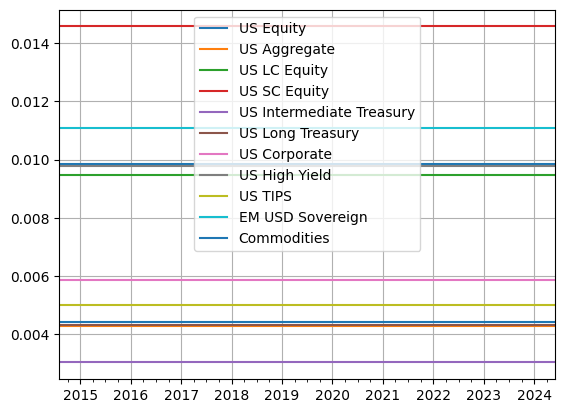

In [60]:
# Predict the returns for the test set
y_test_df = pd.DataFrame(y_test, index=features[model]['Index'][-len(y_test):], columns=y_test.columns)
y_pred_df = pd.DataFrame(pipe.predict(X_test), index=features[model]['Index'][-len(y_test):], columns=y_test.columns)

# Assignign all predictions to the predictions dictionary
predictions[model] = pd.DataFrame(pipe.predict(features[model]['X']), index=features[model]['X'].index, columns=y_test.columns)

# Calculate the MSE reduction for the test set
calculate_mse_reduction(y_test_df, y_pred_df)